<a href="https://colab.research.google.com/github/aidentify/Concepts_and_Apps_of_Deep_Learning/blob/main/mnist_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:
batch_size = 64
test_batch_size = 1000
epochs = 10
lr = 0.01
momentum = 0.01
gpu_use = True
log_interval = 200

cuda_use = gpu_use and torch.cuda.is_available()

print(cuda_use)

device = torch.device("cuda" if cuda_use else "cpu")

# kwargs = {'num_workers': 1, 'pin_memory': True} if cuda_use else {}

print("set hyperparameters done")

False
set hyperparameters done


In [ ]:
transform = transforms.Compose([transforms.ToTensor()]) 

train_loader = torch.utils.data.DataLoader(
  datasets.MNIST('../data', train=True, download=True, 
                 transform=transform), 
    batch_size = batch_size, shuffle=True) #, **kwargs)

test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, download=True,
                 transform=transform), 
    batch_size=test_batch_size, shuffle=True) #, **kwargs)

print('data loading done')

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!
data loading done


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


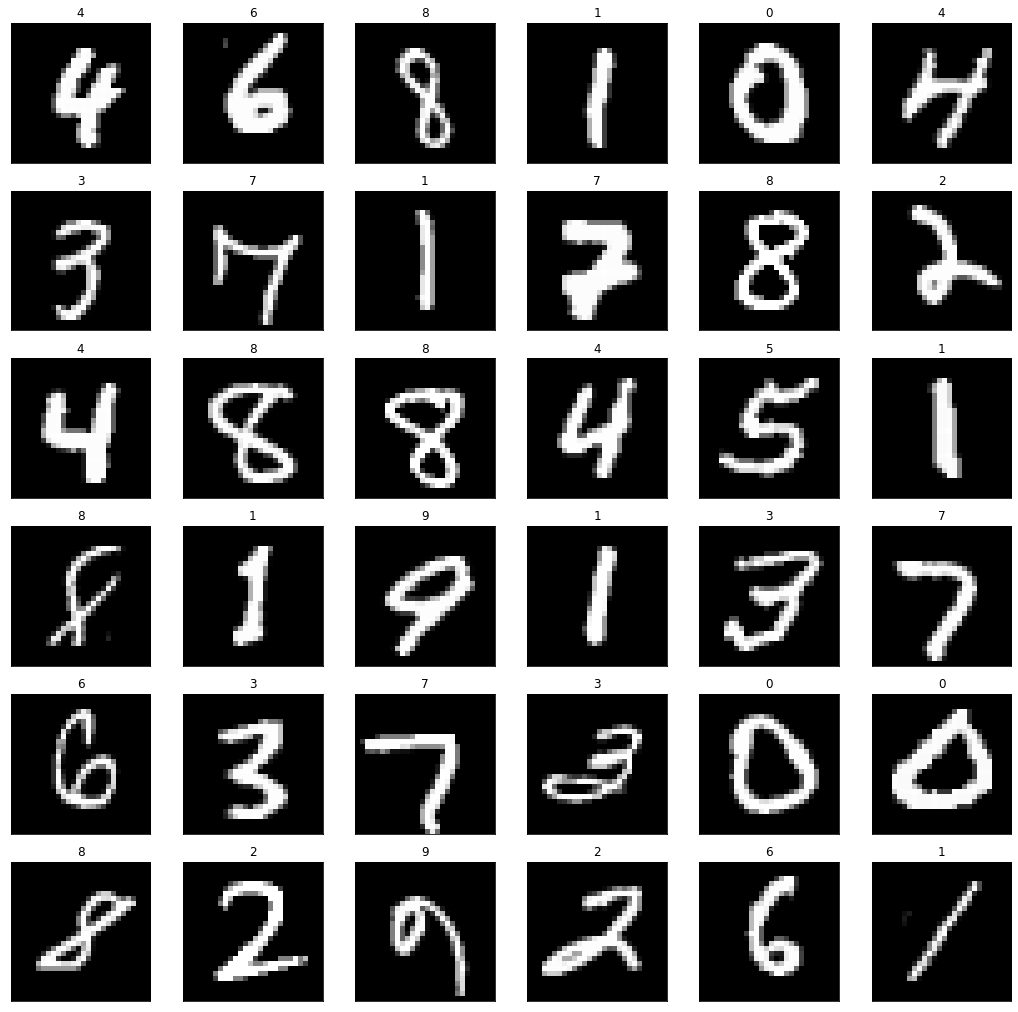

In [ ]:
# obtain one batch of training images
import numpy as np
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot 18" x 18" 
fig = plt.figure(figsize=(18, 18))
for idx in range(36):
    number = fig.add_subplot(6, 6, idx+1, xticks=[], yticks=[])
    number.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    number.set_title(str(labels[idx].item()))

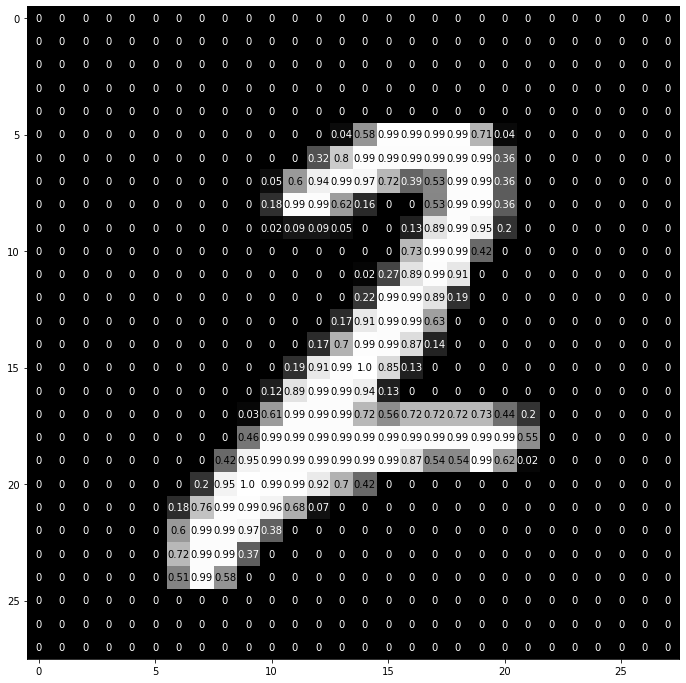

In [ ]:
img = np.squeeze(images[43])

fig = plt.figure(figsize = (12,12)) 
big_number = fig.add_subplot(111)
big_number.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        big_number.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

In [ ]:
## 모델 설계하기

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 150)
        self.fc3 = nn.Linear(150, 50)
        self.fc4 = nn.Linear(50, 10)        

    def forward(self, x):
        x = x.float()
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.log_softmax(x, dim=1)
        return x

print('model design done')

model design done


In [ ]:
model = Net().to(device)
optimizer = optim.RMSprop(model.parameters(), lr=lr) #, momentum=momentum)

print(model)

Net(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=150, bias=True)
  (fc3): Linear(in_features=150, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=10, bias=True)
)


In [ ]:
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(log_interval, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format
          (test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
for epoch in range(1, 11):
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(log_interval, model, device, test_loader)
torch.save(model, './model.pt')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.305283
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.333791
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.581934
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.733008
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.223118

Test set: Average loss: 0.5184, Accuracy: 8242/10000 (82%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.510757
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.384645
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.208545
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.534838
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.490949

Test set: Average loss: 0.3910, Accuracy: 8574/10000 (86%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.239784
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.243169
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.403828
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.263130
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.368729

Test set: Average loss: 0.1816, Accuracy: 9574/10000 (96%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.213855
Train Epoch: 4 [12800/60000 (21%)]	Lo

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


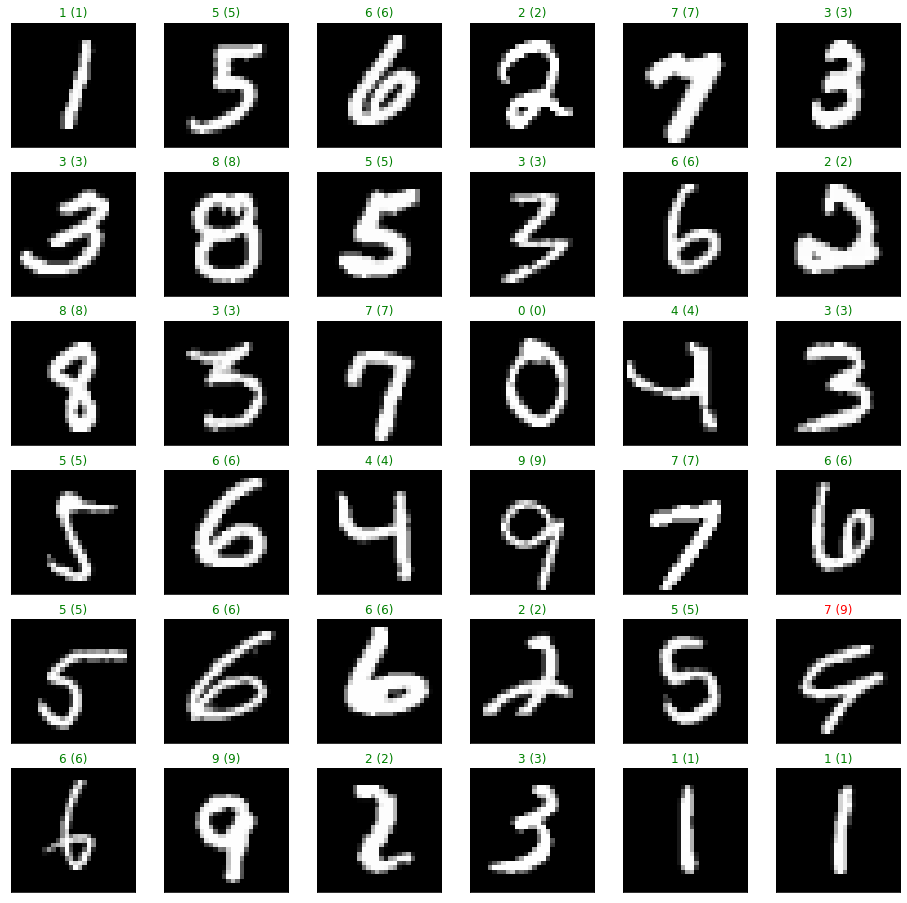

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(16, 16))
for idx in np.arange(36):
    ax = fig.add_subplot(6, 6, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))